In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
chunksize = 10000
data_chunks = []

for chunk in pd.read_csv('C:/Users/allan/src/projects/grupal_project/anomaly_detection/water_ad/water_dataset.csv', chunksize=chunksize):
    data_chunks.append(chunk)

data = pd.concat(data_chunks, ignore_index=True)
data['timestamp'] = pd.to_datetime(data['datetime'], errors='coerce')
data.fillna({'Use_time': data['Use_time'].mean()}, inplace=True)

data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['hour'] = data['timestamp'].dt.hour

In [4]:
scaled_features = ['Use_time', 'month', 'hour']

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[scaled_features])

iso_forest = IsolationForest(n_estimators=200, contamination=0.05, max_samples='auto', random_state=42, n_jobs=-1)
data['anomaly_score'] = iso_forest.fit_predict(data_scaled)
data['decision_function'] = iso_forest.decision_function(data_scaled)

threshold = np.percentile(data['decision_function'], 1)  
data['anomaly'] = (data['decision_function'] < threshold).astype(int)

Q1 = data['Use_time'].quantile(0.25)
Q3 = data['Use_time'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

data['true_anomalies'] = ((data['Use_time'] < lower_limit) | (data['Use_time'] > upper_limit)).astype(int)

precision = precision_score(data['true_anomalies'], data['anomaly'])
recall = recall_score(data['true_anomalies'], data['anomaly'])
f1 = f1_score(data['true_anomalies'], data['anomaly'])

print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precisión: 0.3333
Recall: 0.9804
F1-Score: 0.4975


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[['Use_time', 'month', 'hour']], data['true_anomalies'], test_size=0.2, random_state=42)

iso_forest.fit(X_train)
y_pred = iso_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en los datos de prueba: {accuracy:.4f}")

Precisión en los datos de prueba: 0.0000


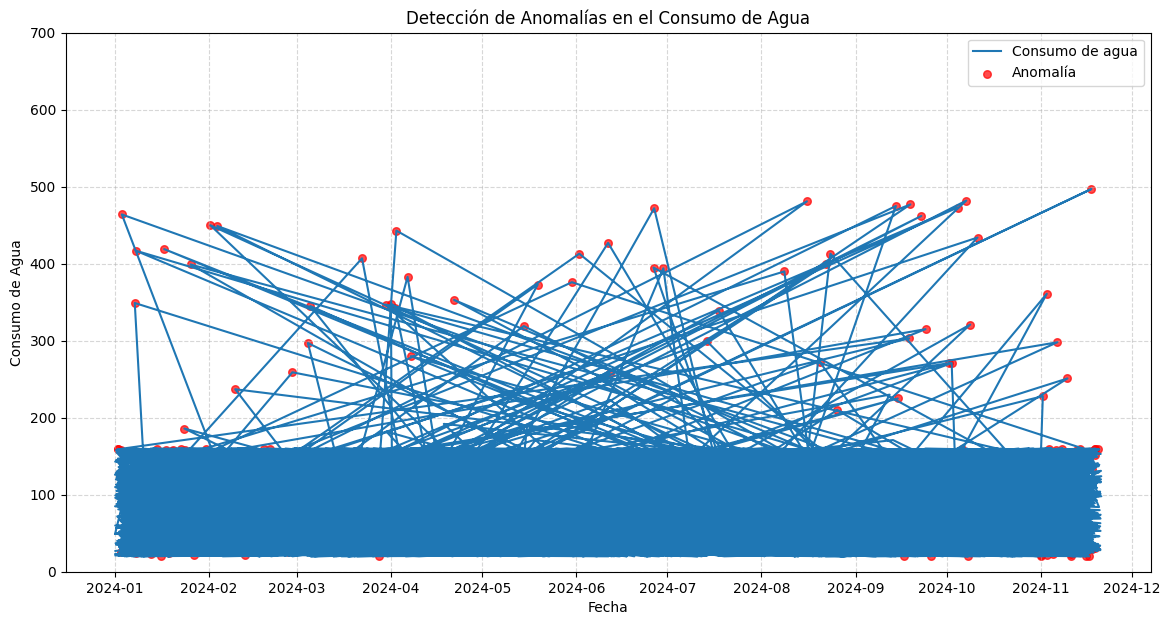

In [6]:
anomalies = data[data['anomaly'] == 1]
plt.figure(figsize=(14, 7))
plt.plot(data['timestamp'], data['Use_time'], label='Consumo de agua', linewidth=1.5)
plt.scatter(anomalies['timestamp'], anomalies['Use_time'], color='red', label='Anomalía', marker='o', s=30, alpha=0.7)
plt.title('Detección de Anomalías en el Consumo de Agua')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Agua')
plt.ylim(0, 700)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()